In [1]:
import mira
import scanpy as sc
import anndata
import pandas as pd

mira.utils.wide_view()

In [2]:
atac_data = anndata.read_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/lite_atac_data.h5ad')
rna_data = anndata.read_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/hair_follicle.h5ad')

rna_model = mira.topics.ExpressionTopicModel.load('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/Shareseq_rna_model_rev1.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/shareseq_atac_model_rev1.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


rna_data.obs['ordered_cells'] = rna_data.obs.mira_pseudotime.argsort().argsort()[::-1]
ax = mira.pl.plot_stream(rna_data[rna_data.obs.tree_states.str.contains('Cortex') & (rna_data.obs.mira_pseudotime > 6)], data = ['mira_pseudotime', 'LEF1'], 
                style = 'scatter', pseudotime_triangle=False, clip = 2, palette='Set2', layers = [None, 'smoothed'], max_bar_height=0.8,
               window_size=501, orientation='v', tree_structure=False, pseudotime_key = 'ordered_cells', 
                         log_pseudotime=False, scale_features = True)
#ax[1].set(ylim = (-5,10))
ax[1].axis('on')

In [14]:
import sklearn

In [3]:
import numpy as np
from scipy import sparse
from lisa.core.genome_tools import Region
import warnings
import matplotlib.patches as patches
import tqdm

def _residual_transform(X, pi_j_hat, n_i):
    
    assert(isinstance(X, np.ndarray))
    assert(isinstance(pi_j_hat, np.ndarray))
    assert(isinstance(n_i, np.ndarray))
    pi_j_hat = np.squeeze(pi_j_hat)[np.newaxis, :]
    n_i = np.squeeze(n_i)[:, np.newaxis]

    mu_ij_hat = n_i * pi_j_hat

    count_dif = n_i - X
    expected_count_dif = n_i - mu_ij_hat

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        r_ij = np.multiply(
            np.sign(X - mu_ij_hat), 
            np.sqrt(
            np.where(X > 0, 2 * np.multiply(X, np.log(X / mu_ij_hat)), 0) + \
            2 * np.multiply(count_dif, np.log(count_dif / expected_count_dif))
            )
        )

    return np.clip(np.nan_to_num(r_ij), -10, 10)

def _get_pi(X):
    return np.array(X.sum(0)).reshape(-1)/X.sum()

def _get_n(X):
    return np.array(X.sum(-1)).reshape(-1)


def _make_regpanel(ax,*, accessibility, chrom, start, end, peaks, time):

    accessibility.data = np.ones_like(accessibility.data)
    n_i = _get_n(accessibility)
    p_i = _get_pi(accessibility)

    interval = Region(chrom, start, end)

    overlapped_peaks = np.array([
        Region(*peak).overlaps(interval)
        for peak in peaks
    ])
    
    order = time.argsort()

    X = accessibility[:, overlapped_peaks].toarray()[order, :]

    residuals = _residual_transform(X, p_i[overlapped_peaks], n_i)

    ax.set(xlim = (start, end), ylim = (0, len(residuals)))
    t_ = iter(tqdm.trange((residuals > 0).sum(), desc = 'Plotting fragments'))

    for alpha, position in zip(residuals.T, peaks[overlapped_peaks]):
        
        start, end = (int(position[1]), int(position[2]))
        min_, max_ = alpha.min(), alpha.max()
        transparency = (alpha - min_)/(max_ - min_)
        
        for j, a in enumerate(alpha):
            if a > 0:
                ax.add_patch(
                    patches.Rectangle((start, j), (end - start), 1, color = 'black', alpha = transparency[j])
                )
                next(t_)

    ax.invert_yaxis()

In [4]:
litemodel = mira.rp.LITE_Model(expr_model=rna_model, accessibility_model=atac_model, genes = ["LEF1"]).load('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/rp_models/')

In [6]:
import matplotlib.pyplot as plt

In [8]:
test = pd.read_csv('/Users/alynch/genomes/mm10/canonical_tss.tsv', sep = '\t')
test.columns = test.columns.str.split('.').str.get(-1)
test['val'] = 0
test = test.dropna()
test = test.drop_duplicates(subset = 'geneSymbol')
test['geneSymbol'] = test.geneSymbol.str.upper()

mira.tl.get_distance_to_TSS(atac_data, tss_data = test, genome_file='/Users/alynch/genomes/mm10/mm10.genome')

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [10]:
import pygenometracks
import pandas as pd

100%|██████████| 55304/55304 [00:02<00:00, 20130.85it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
Trying to set attribute `.obs` of view, copying.


[(0.0, 3651.0)]

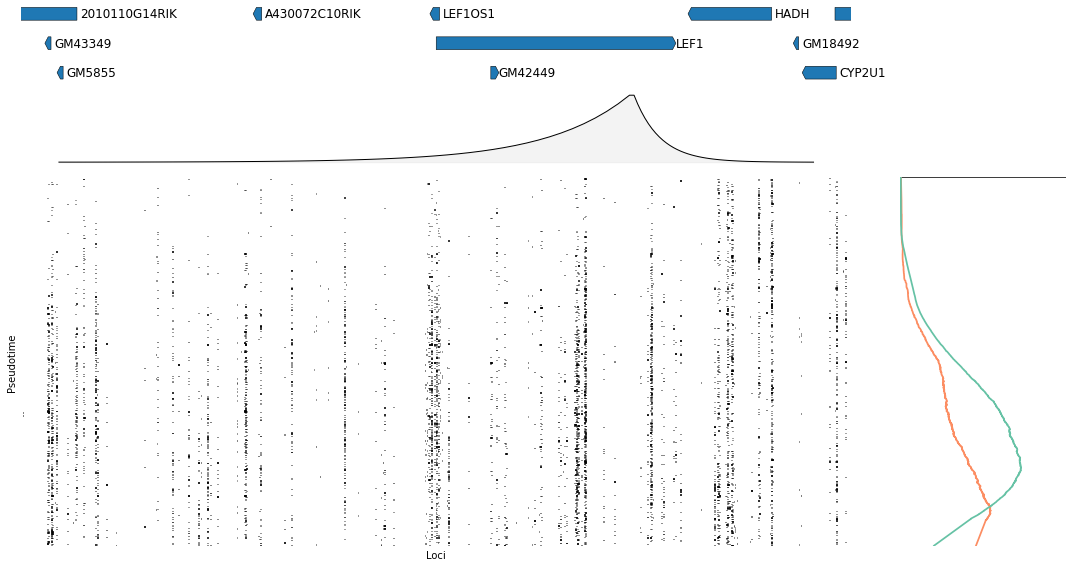

In [13]:
#fig, ax = plt.subplots(1,1,figsize=(10,5))
cells = atac_data[rna_data.obs_names[rna_data.obs.tree_states.str.contains('Cortex')]]
fig5 = plt.figure(constrained_layout=False, figsize=(15,8))
widths = [5, 1]
heights = [1, 1, 5]
spec5 = fig5.add_gridspec(ncols=2, nrows=3, width_ratios=widths,
                    height_ratios=heights)

fragments_ax = fig5.add_subplot(spec5[2,0])
for spine in ['left','right','top','bottom']:
    fragments_ax.spines[spine].set_visible(False)
fragments_ax.set(xlabel = 'Loci', ylabel = 'Pseudotime', xticks = [], yticks = [])
_make_regpanel(fragments_ax, accessibility = cells.X, chrom = 'chr3', time = rna_data.obs[rna_data.obs.tree_states.str.contains('Cortex')].mira_pseudotime,
               start = 131110470-2e5, end = 131110470+2e5, peaks = cells.var[['chr','start','end']].values)


rp_axes = fig5.add_subplot(spec5[1,0])
rp_axes.axis('off')
mira.plots.rp_plots._plot_rp_models(rp_axes, 
        interval_chrom = 'chr3', interval_start = 131110470-2e5, interval_end = 131110470+2e5, rp_models = litemodel, 
        gene_id = atac_data.uns['TSS_metadata']['gene'], 
                chrom = atac_data.uns['TSS_metadata']['chromosome'], 
                start = atac_data.uns['TSS_metadata']['txStart'],
                end = atac_data.uns['TSS_metadata']['txEnd'], 
                strand = atac_data.uns['TSS_metadata']['strand'])

track = pygenometracks.BedTrack(dict(file = 'data/shareseq/testbed.bed', section_name = 'Track'))
track_ax = fig5.add_subplot(spec5[0,0])
track_ax.set(xlim = (131110470-2e5, 131110470+2e5))
track.plot(track_ax, 'chr3', 131110470-2e5, 131110470+2e5)
track_ax.axis('off')

streamax = fig5.add_subplot(spec5[2,1])
rna_cells = rna_data[cells.obs_names]
rna_cells.obs['ordered_cells'] = len(rna_cells) - rna_cells.obs.mira_pseudotime.argsort().argsort()
mira.pl.plot_stream(rna_cells, data = ['LEF1','LEF1'], layers = ['LITE_prediction','normalized'],
                style = 'line', pseudotime_triangle=False, clip = 2, palette='Set2', max_bar_height = 0.99,
               window_size=501, orientation='v', tree_structure=False, pseudotime_key = 'ordered_cells', 
                         log_pseudotime=False, scale_features = True, show_legend = False,
                   ax = streamax)
streamax.set(ylim = (0, len(cells) + 1))
               
#ax[1].set(ylim = (-5,10))

In [9]:
litemodel = mira.rp.LITE_Model(expr_model=rna_model, accessibility_model = atac_model, genes = ['LEF1','KRT35']).load('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/rp_models/')

In [11]:
test[['chrom','txStart','txEnd','geneSymbol','val','strand']].to_csv('data/shareseq/testbed.bed',sep = '\t',
                            index = None, header = None)

In [49]:
import anndata
import numpy as np
import tqdm
import warnings

In [29]:
atac_data = anndata.read_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/lite_atac_data.h5ad')
rna_data = anndata.read_h5ad('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/hair_follicle.h5ad')

In [40]:
def _residual_transform(X, pi_j_hat, n_i):
    
    assert(isinstance(X, np.ndarray))
    assert(isinstance(pi_j_hat, np.ndarray))
    assert(isinstance(n_i, np.ndarray))
    pi_j_hat = np.squeeze(pi_j_hat)[np.newaxis, :]
    n_i = np.squeeze(n_i)[:, np.newaxis]

    mu_ij_hat = n_i * pi_j_hat

    count_dif = n_i - X
    expected_count_dif = n_i - mu_ij_hat

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        r_ij = np.multiply(
            np.sign(X - mu_ij_hat), 
            np.sqrt(
            np.where(X > 0, 2 * np.multiply(X, np.log(X / mu_ij_hat)), 0) + \
            2 * np.multiply(count_dif, np.log(count_dif / expected_count_dif))
            )
        )

    return np.clip(np.nan_to_num(r_ij), -10, 10)

def get_pi(X):
    return np.array(X.sum(0)).reshape(-1)/X.sum()

def get_n(X):
    return np.array(X.sum(-1)).reshape(-1)

In [98]:
X = atac_data.X.tocsc()
X.data = np.ones_like(X.data)

In [101]:
atac_data.obs['n_i'] = get_n(X)
atac_data.var['pi'] = get_pi(X)

In [120]:
atac_data.var.pi.argmax()

0

In [102]:
from lisa.core.genome_tools import Region

In [172]:
test.set_index('geneSymbol').loc['Lef1']

name          ENSMUST00000106341.8
chrom                         chr3
strand                           +
txStart                  131110470
txEnd                    131224356
chromStart             131110470.0
chromEnd               131224356.0
transcript    ENSMUST00000106341.8
val                              0
Name: Lef1, dtype: object

In [173]:
bounds = Region('chr3', 131110470 - 2e5, 131224356+2e5)

In [174]:
atac_data.var['in_plot'] = [
    Region(chrom, start, end).overlaps(bounds)
    for (chrom, start, end) in atac_data.var[['chr','start','end']].values
]

In [175]:
cells_in_plot = atac_data[rna_data.obs_names[rna_data.obs.tree_states.str.contains('Cortex')], 
                         atac_data.var.in_plot]
cells_in_plot = cells_in_plot[
    rna_data[rna_data.obs.tree_states.str.contains('Cortex')].obs.mira_pseudotime.argsort()[::-1]
]

In [176]:
arr = cells_in_plot.X.toarray()
#arr[:,0] = np.random.rand(arr.shape[0]) < 0.5
residuals = _residual_transform(
    arr, cells_in_plot.var.pi.values, cells_in_plot.obs.n_i.values
)

In [177]:
import seaborn as sns
import matplotlib.patches

width = 10
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.set(xlim = (bounds.start, bounds.end), ylim = (0, -len(residuals)))
t_ = iter(tqdm.trange((residuals > 0).sum()))

for alpha, position in zip(residuals.T, cells_in_plot.var[['chr','start','end']].values):
    
    start, end = (int(position[1]), int(position[2]))
    min_, max_ = alpha.min(), alpha.max()
    transparency = (alpha - min_)/(max_ - min_)
    
    for j, a in enumerate(alpha):
        if a > 0:
            ax.add_patch(
                patches.Rectangle((start, -j), (end - start), 1, color = 'black', alpha = transparency[j])
            )
            next(t_)

In [197]:
bounds.strand

AttributeError: 'Region' object has no attribute 'strand'

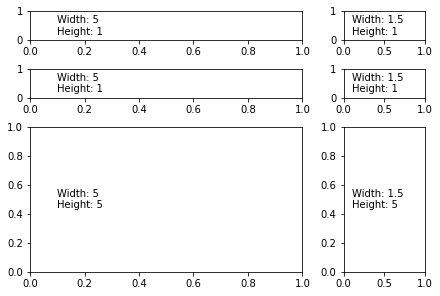

In [191]:
fig5 = plt.figure(constrained_layout=True)
widths = [5, 1.5]
heights = [1, 1, 5]
spec5 = fig5.add_gridspec(ncols=2, nrows=3, width_ratios=widths,
                          height_ratios=heights)
for row in range(3):
    for col in range(2):
        ax = fig5.add_subplot(spec5[row, col])
        label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

In [200]:
atac_data.uns['distance_to_TSS_genes']

array(['4933401J01RIK', 'GM26206', 'XKR4', ..., 'GM21742', 'GM21748',
       'AC234645.1'], dtype=object)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 